# Data structures and algorithms for spell checking and correction

By Robin William Hundt, University of Göttingen  
Inspired by John Bentleys article "A spelling checker" [1]  
<br>
Git: https://gitlab.gwdg.de/robinwilliam.hundt/programming-pearls-spelling-checker

# Table of contents

1. [Introduction](#intro)
2. [Spell checking](#spell-checking)
    1. [Original spell program and Python implementation](#spell)
    2. [Testing the implementation](#testing-spell)
    3. [Trie data structure](#trie-data-structure)
    4. [Testing of trie and benchmarks](#testing-trie)
    5. [Spell checking: conclusion](#checking-conclusion)
3. [Spelling correction](#spell-correcting)
    1. [Distance of strings](#string-distance)
    2. [Frequency of strings and fast corrector](#freq-fast-corrector)
    3. [Symmetric delete spelling correction (SymSpell)](#sym-spell)
    4. [SymSpell benchmarks](#testing-sym-spell)
    5. [Corrector accuracy](#corrector-accuracy)
    6. [Spelling correction: conclusion](#correcting-conclusion)
4. [References](#references)
    1. [Data sources](#data-sources)
    2. [Libraries](#libraries)

# Introduction <a name="intro"/>

This notebook is a technical preparation about data structures and algorithms for spell checking and correction.  
It has been developed for the *Programming pearls* seminar at the university of Goettingen (May - June 2018) and is inspired by John Bentleys article *A spelling checker* which was part of his *programming pearls* article series[1].  
  
All relevant data sources are included in the repository.

### Dependencies
To install the necessary dependencies simply execute within a cell or a terminal (here without the !)
```bash
!pip install --user -r requirements.txt
```

In [3]:
# just some boring imports
from io import StringIO
from time import sleep
from typing import Set, Tuple, Iterable, Callable, List, Dict
from types import MethodType
from functools import partial
import re
import timeit
import gc

import marisa_trie
import numpy as np
import matplotlib.pyplot as plt
from pympler.asizeof import asizeof
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

%load_ext memory_profiler
%matplotlib inline

# small decorator to split class definitions over several slides
def add_to_class(cls):
    def decorator(fn):
        setattr(cls, fn.__name__, fn)
        return fn
    return decorator

# Spell checking <a name="spell-checking"/>
## Original spell program and Python implementation <a name="spell"/>

In 1975 Steve Johnson wrote the first version of the `spell` program[1]. The improved version by Douglas McIlroy would later become the standard english language spell checker on Unix (introduced in v7 [2]).  
The original version is particularly interesting for it's simplicity and clever combination of already existing porgrams with highly specific functions into a new program that has a clearly defined functionality:

![](spell-checker-diagram.svg)

Reconstructed version of Steve Johnsons spell (Kernighan and Bauer, Software Tools in Pascal)

``` bash
prepare filename |                 # remove formatting commands
    translit A-Z a-z |             # map upper to lower case
        translit ^a-z @n |         # remove punctuation
            sort |                 # put words in alphabetical order
                unique |           # remove duplicate words
                    common -2 dict # report words not in dictionary
```
*source: [1]*

The shell pipeline operator `|` is used to *pipe* the output of the program on the left side to the program on the right side as its input. Using this, several porgrams can be chained together in a clear and concise way.
  
Unfortunately there is no *pipe* operator in Python, but by utilizing the comprehensive standard libraries we can implement nearly the same functionality that the original `spell` offered in a few lines of code.

In [4]:
def spell(filename: str, word_dict: str) -> Set[str]:
    w = set(word_dict.lower().split('\n'))
    with open(filename) as f:
        return set(re.sub(r"[^a-z]", "\n", f.read().lower()).split('\n')) - w

This version however has, some of the same shortcomings as Steve Johnsons, e.g. `isn't` is converted to `isn` and `t` which aren't english words, but `isn't` is.

## Testing the implementation <a name="testing-spell"/>
In order to test the function we need two things:  
1. A text file with a big amount of english text
2. A dictionary where we look up the words of the input text  

As a text file we can use the `big.txt` file provided by [Peter Norvig](http://norvig.com/) [D1] which is a concatination of public domain book excerpts from [Project Gutenberg](http://www.gutenberg.org/wiki/Main_Page)(inaccessible with a german IP) and lists of most frequent english words.  
Following is the number of words inside that fille and a small excerpt.

In [5]:
!echo word count: $(wc -w big.txt) '\n'
!head -n 5000 big.txt | tail -n 1

word count: 1095695 big.txt 

"You can easily imagine, Mr. Holmes, how curious I became as to what the meaning of this extraordinary performance could possibly be. They were always very careful, I observed, to turn my face away from the window, so that I became consumed with the desire to see what was going on behind my back. At first it seemed to be impossible, but I soon devised a means. My hand-mirror had been broken, so a happy thought seized me, and I concealed a piece of the glass in my handkerchief. On the next occasion, in the midst of my laughter, I put my handkerchief up to my eyes, and was able with a little management to see all that there was behind me. I confess that I was disappointed. There was nothing. At least that was my first impression. At the second glance, however, I perceived that there was a man standing in the Southampton Road, a small bearded man in a grey suit, who seemed to be looking in my direction. The road is an important highway, and there are usually 

So we have our big text file of english text, now we need a dictionary.
Luckily on most Unix and Unix-like systems there is a comprehensive newline delimeted dictionary text file available. The file usually resides under `/usr/share/dict/words` od `/usr/dict/words`. To ensure portability the file is also available inside the repository as `american-english`.

In [6]:
!echo word count: $(wc -w american-english) '\n'
!head -n 5000 american-english | tail

word count: 99171 american-english 

Eula
Eula's
Euler
Eumenides
Eumenides's
Eunice
Eunice's
Euphrates
Euphrates's
Eurasia


We read in the dictionary file as a single string to be passed to our Python version of `spell`.

In [47]:
with open('american-english') as w:
    words_file = w.read()

Now that we have the necessary files requiered to assess the quality of our implementation we must ask ourselves: What do we actually want to test?  
Three things come to mind:  
1. The number of unique false positives
2. The memory consumption of the function
3. The execution time of the function
  
### False positives
In the following cell we first calculate the number of unique words in the `big.txt` file, then pass it to the spell checking function and output the number of unique misspelled words as well as a slice of the error set.

In [8]:
with open('big.txt') as f:
    num_unique_words = len(set(f.read().split()))
f"Number of individual words in big.txt: {num_unique_words}" 
errors = spell('big.txt', words_file)
f"Number of individual misspelled words: {len(errors)}"
list(errors)[:10]

'Number of individual words in big.txt: 81397'

'Number of individual misspelled words: 5065'

['ll',
 'cornfields',
 'gras',
 'ranula',
 'pahlen',
 'posen',
 'godfreys',
 'coxa',
 'deltoid',
 'dorokhov']

Around five thousand unique words of the original eigthy thousand unique words are declared as misspelled by our `spell` version. However when we look at some of the words that are declared as wrong we see that they contain a lot of (medical) technical terms like iodides, leucocytes, hyperostosis or names like Shrewsbury and Newtown.  
Apparently writing a minimal spelling checker is an easy task, however to use it productively, great care has to be put into the dictionary that is used as the basis. 
  
Since the quality of a spelling checker in terms of false-positives largely depends on the dictionary used, we'll mainly look at the other two metrics, memory consumption and execution time.

### Rough estimate of memory consumption



Since doing an analytical analysis of the memory consuption of an algorithm is a difficult task when using many library functions, we instead try to assess the memory footprint empirical.  
In order to do this we change the first version of spell to handle file like objects that have a `read()` method instead of file names or paths. 

In [9]:
# this version excpects a file object instead of a file name
def spell2(file, word_dict: str) -> Set[str]:
    w = set(word_dict.lower().split('\n'))
    return set(re.sub(r"[^a-z]", "\n", file.read().lower()).split('\n')) - w

Using the adapted version and the [memory_profiler](https://pypi.org/project/memory_profiler/) package we can get an idea of the memory requierements during the execution of the algorithm.
It should be noted however, that the output of the `%memit` magic command at times seems highly erratic. It is very likely to produce different results on different runs.

In [75]:
with open('big.txt') as f:
    text = f.read()

out_mem = []
gc.disable()
for i in range(1, 16):
    char_count = (len(text) // 15) * i
    unique_word_count = len(set(text[:char_count].split()))
    text_io = StringIO(text[:char_count])
    tmp = %memit -o -q spell2(text_io, words_file)
    tmp = (unique_word_count, tmp.mem_usage[0] - tmp.baseline)
    text_io.close()
    out_mem.append(tmp)
gc.enable()

Although the actual MB numbers should be taken with a grain of salt, the data suggest that we have a polynomial relationship between the number of unique words in the input and the amount of memory allocated during the execution.

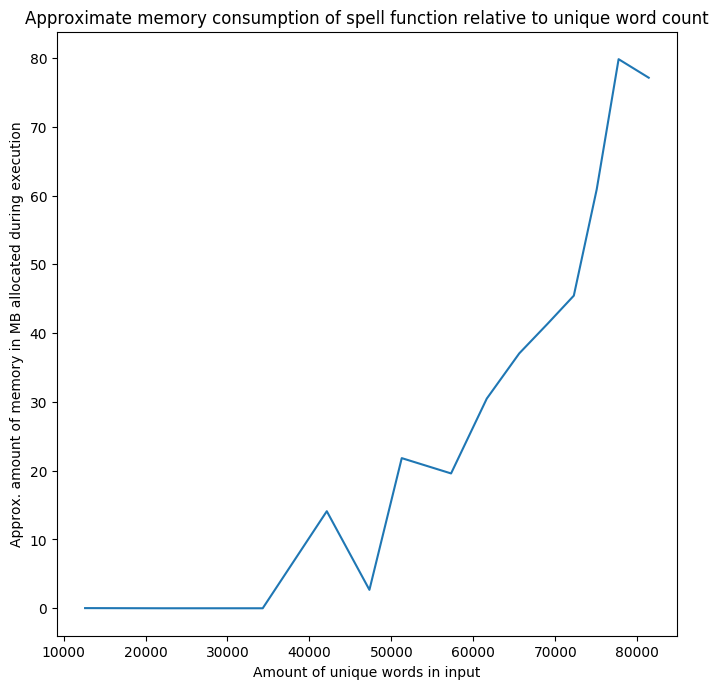

In [98]:
uniq_word_counts, memory = list(zip(*out_mem))
plt.figure(dpi=100, figsize=(8,8));
plt.title("Approximate memory consumption of spell function relative to unique word count")
plt.xlabel("Amount of unique words in input")
plt.ylabel("Approx. amount of memory in MB allocated during execution")
plt.plot(uniq_word_counts, memory);

### Benchmark of execution time

The last metric and also the most important one is the execution time.  
We again use the adapted version of the spell function in order to execute the function on partitons of the original file that are linearly increasing in size.

In [12]:
def time_spell_func(text, spell_func, num_partitions=15, runs_per_partition=20):
    """ This function time the execution of one of the spell like functions by partitioning the passed text 
        into num_partitions chunks where each chunk is len(text)//num_partitions bigger than the 
        previous one (the chunk sizes are are increasing linearly).
        This function deliberately sets -n 1 -r 1 for the %timeit magic command to prevent caching issues.
    """
    timing_data = []
    gc.disable()
    for i in range(1, num_partitions+1):
        char_count = (len(text) // num_partitions) * i
        run_times = []
        for _ in range(runs_per_partition):
            text_io = StringIO(text[:char_count])  # provide file like object of partition of orginal file
            tmp = %timeit -q -o -n 1 -r 1 spell_func(text_io) # timeit magic command is used to collect timings
            run_times.append(tmp.best)
            text_io.close()
        timing_data.append((char_count, run_times))
    gc.enable()
    return timing_data

Looking at the plotted data, we can clearly see that there is a linear relationship between the execution time and the amount of characters in the input file. 

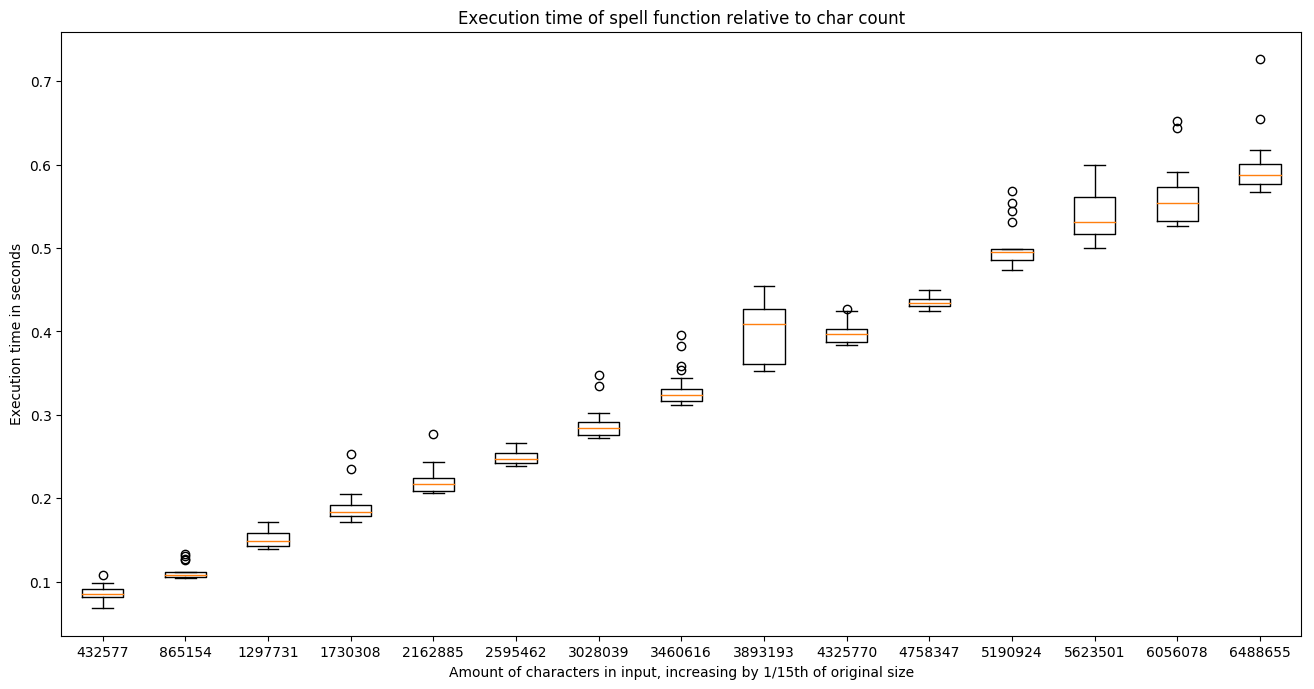

In [13]:
char_counts, time_spell = list(zip(*time_spell_func(text, partial(spell2, word_dict=words_file))))
plt.figure(dpi=100, figsize=(16,8));
plt.title("Execution time of spell function relative to char count")
plt.xlabel("Amount of characters in input, increasing by 1/15th of original size")
plt.ylabel("Execution time in seconds")
plt.boxplot(time_spell, labels=char_counts);

### That is quite fast for a 1 million words file!

The speed is actually quite good, compared to the already optimized version of `spell` by Doug McIlroy (written in 1978). That version managed to check a 5,000 word document in **under 30 seconds** (on a VAX-11/750 with 3.125 MHz)[1]. The dramatic decrease in spell checking time (30 seconds for 5,000 words compared to ~0.6-1.0 seconds for nearly 1,000,000 words) can be partly attributed to a tremendous increase in computing power but is also due to the `spell2` version not actually loading the file to be checked from disk, but using a StringIO object that is already loaded into memory and has thus considerably lower access times.

### But can we do better?


## Trie data structure <a name="trie-data-structure"/>

<div>
    <img src="Trie.svg" width=300 height=600>
    <a href="https://de.wikipedia.org/wiki/Trie#/media/File:Trie.svg">Trie.svg</a> created by <a href="https://de.wikipedia.org/wiki/Benutzer:Nd">nd</a> (<a href="https://creativecommons.org/licenses/by-sa/3.0/">CC BY-SA 3.0</a>)
</div>


We can use a **Trie** or "prefix-tree", which is an ordered tree data structure, to efficiently store all the words from our dictionary.  
The nodes themselves don't carry information about the key they're storing, instead the key is solely encoded in the position of the node and the information associated with the edges inside it.
In theory, this structure allows us to look up words in $O(length(word))$ while saving the strings in a compressed way, but will it actually be better than using standard Python sets?

Simple Node object that solely stores information about neighbouring nodes and which letter the the connecting edges represent. Edge information is saved inside Python dictionaries to ensure fast $O(1)$ access.

In [14]:
class IllegalTrieEdge(Exception):
    pass

class Node:
    def __init__(self):
        self.edges = {}
        self.end_of_word = False  # note that not only leaves can be valid words, but also intermediate nodes
        
    def add_edge(self, ch: str):
        if len(ch) != 1:
            raise IllegalTrieEdge('Edges can only consist of one character')
        if ch not in self.edges:
            self.edges[ch] = Node()
        return self.edges[ch]
    
    def get_edge(self, ch: str):
        return self.edges.get(ch)
    
    def __contains__(self, edge: str):
        return edge in self.edges

Basis of the Trie class with helper method `_find_last_prefix_node()` method.

In [15]:
class Trie:
    def __init__(self, words=[]):
        self.root = Node()
        self._build_trie(words)
        
        
    def _find_last_prefix_node(self, word: str) -> Tuple[str, Node]:
        """ Helper method that, given a word, returns a tuple consisting of the prefix 
            of the word that is contained in the trie and the Node within the trie representing 
            the end of the prefix. Should the word not be saved in the trie, an empty string
            and the root is returned. If the trie contains the full word then prefix == word.
        """
        v = self.root
        prefix = ''
        while len(word) > 0 and word[0] in v:
            prefix += word[0]
            v = v.get_edge(word[0])
            word = word[1:]
        return prefix, v

The `_find_last_prefix_node()` method can be used to easily implement the addition of words as well as the `__contains__()` [magic method](https://rszalski.github.io/magicmethods/).

In [16]:
@add_to_class(Trie)
def _add_word(self, word: str):
    """ Helper method that adds a single word to the trie.
    """
    prefix, node = self._find_last_prefix_node(word)
    if prefix == word:
        node.end_of_word = True
    word = word[len(prefix):]
    while len(word) > 0:
        node = node.add_edge(word[0])
        word = word[1:]
    node.end_of_word = True

Build up a trie by repeatedly calling `_add_word()` with the contents of the passed Iterable `words`.

In [17]:
@add_to_class(Trie)
def _build_trie(self, words: Iterable[str]):
    for word in words:
        self._add_word(word)

Implementing the `__contains_()` magic method allows us to use the `in` operator to test for membership.

In [18]:
@add_to_class(Trie)
def __contains__(self, word: str) -> bool:
    prefix, node = self._find_last_prefix_node(word)
    return prefix == word and node.end_of_word

## So lets test it, shall we?  <a name="testing-trie"/>
As the dictionary to store inside the trie we'll again use the standard english words file on unix systems, splitted at newlines.

In [19]:
with open('american-english') as w:
    words_file = w.read()  
    words = [word for word in words_file.split('\n') if len(word) > 0]

### Quick test of our implementation
In order to quickly test our implementation we can use a list comprehension that should output all the words from our dictionary file for which the Trie membership test returns false. To verify that the `__contains__()` method doesn't just always output `True` we also test for membership of two words that are **not** in the dictionary.

In [20]:
trie = Trie(words)

In [21]:
[word for word in words if word not in trie]
'adasedadwa'  in trie
'Hallo' in trie

[]

False

False

### Memory decrease by using a prefix tree (trie)....
Did we accomplish a reduction of memory used by the dictionary by utilizing this, in theory efficient datastructure?  
In order to test this we can use the [pympler](https://pypi.org/project/Pympler/) python package that is able to recursively estimate the size of Python objects.

In [22]:
size_words_file = asizeof(words_file)
size_words = asizeof(words)
size_trie = asizeof(trie)
f"Size read file: {size_words_file} B; size word list: {size_words} B; size of trie: {size_trie} B"
f"Increase in size by factor {size_trie/size_words_file}"

'Size read file: 938664 B; size word list: 6884128 B; size of trie: 93362984 B'

'Increase in size by factor 99.46368881729778'

### An increase by a factor of ~ 100 ?! 

Python is a highly dynamic language where **everything** is an object, even simple things like an integer or character. This adds an immense overhead, which results in this dramatic increase in size.  
So saving space by using a prefix tree implemented in native Python is not possible, due to the limitations of the language.  

### But maybe it is at least fast?  

We adapt the `spell` function from earlier to calculate $A \backslash B$ where $A = \{w | w$ in file$\}$ and 
$B = \{w | w$ in dictionary$\}$ and $B$ is a Python object implementing the `__contains__()` method.

In [23]:
def spell_G(file, word_dict) -> Set[str]:
    return {
        word for word in
        # read the file to check -> convert to lower -> split at newlines 
        # -> remove punctuation -> remove double occurences (conv. to set)
        set(re.sub(r"[^a-z']", "\n", file.read().lower()).split('\n'))
        if word not in word_dict
    }

In [24]:
char_counts, time_spell_trie = list(zip(*time_spell_func(text, partial(spell_G, word_dict=trie))))

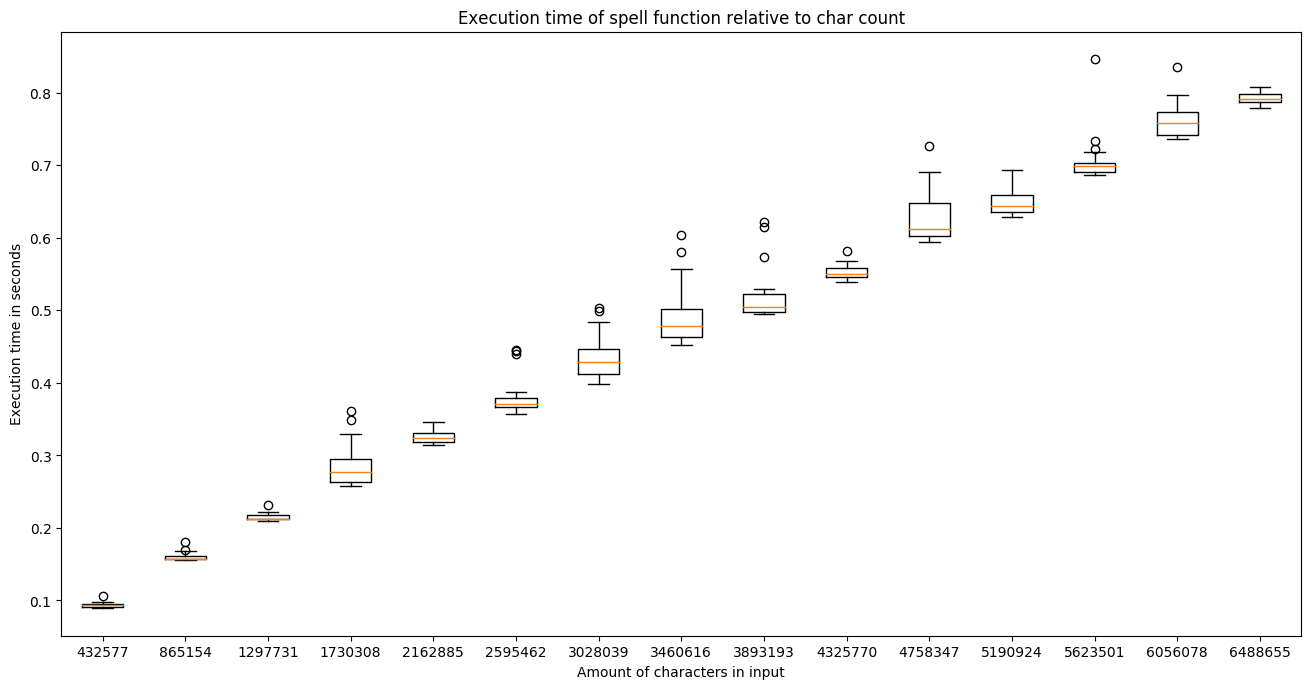

In [25]:
plt.figure(dpi=100, figsize=(16,8));
plt.title("Execution time of spell function relative to char count")
plt.xlabel("Amount of characters in input")
plt.ylabel("Execution time in seconds")
plt.boxplot(time_spell_trie, labels=char_counts);

#### Quite underwhelming
It seems that it's not only not possible to save memory by implementing a trie datastructure in Python but that there is also no reduction of execution time.

Nevertheless maybe we can finally gain something by further utilizing the vast Python ecosysytem and instead of using a pure Python implementation of a trie, we use a wrapper for a c++ implementation.  
The package of choice is [marisa-trie](https://pypi.org/project/marisa-trie/)

In [26]:
trie_efficient = marisa_trie.Trie(words)

In [27]:
char_counts, time_spell_marisa = list(zip(*time_spell_func(text, partial(spell_G, word_dict=trie_efficient))))

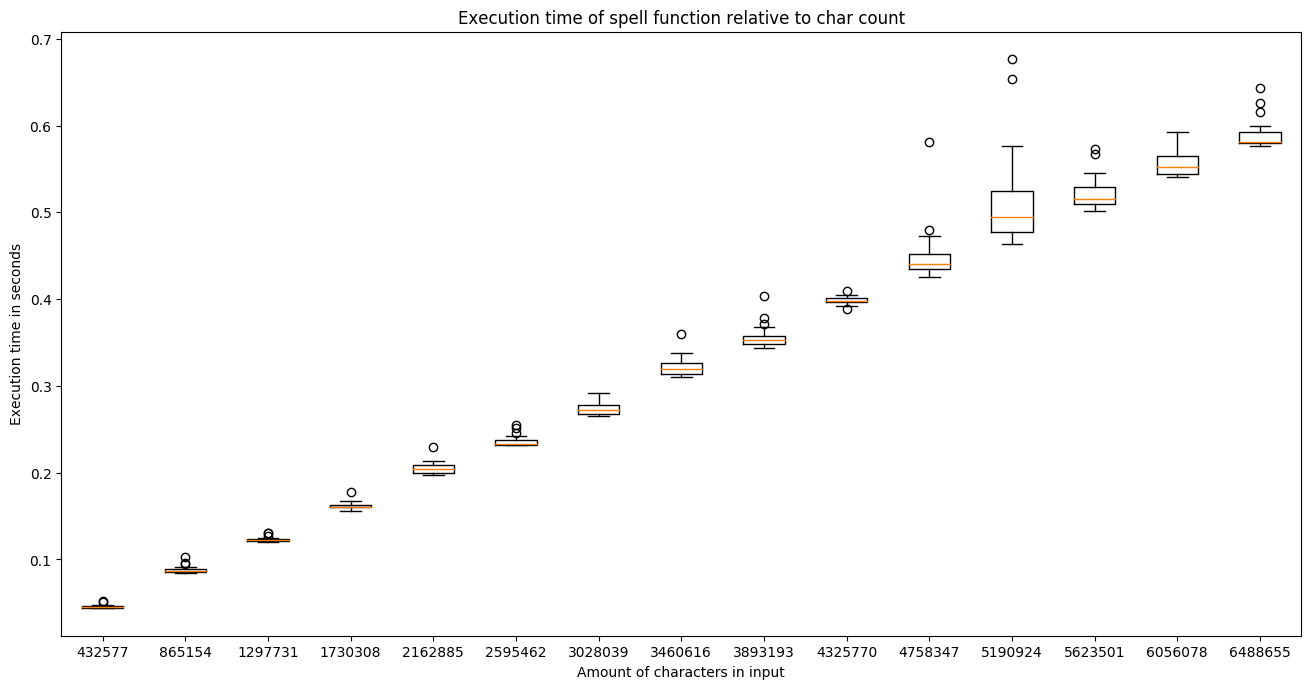

In [28]:
plt.figure(dpi=100, figsize=(16,8));
plt.title("Execution time of spell function relative to char count")
plt.xlabel("Amount of characters in input")
plt.ylabel("Execution time in seconds")
plt.boxplot(time_spell_marisa, labels=char_counts);

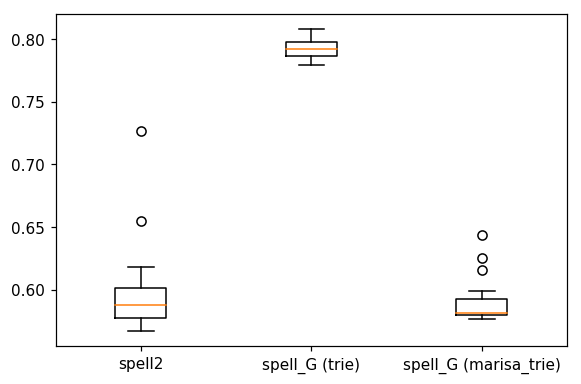

In [29]:
data = [time_spell[-1], time_spell_trie[-1], time_spell_marisa[-1]]
plt.figure(dpi=110, figsize=(6,4));
plt.boxplot(data, labels=['spell2', 'spell_G (trie)', 'spell_G (marisa_trie)']);

## Spell checking: Conclusion <a name="checking-conclusion"/>

Implementing a usable spelling checker in Python only takes a couple of minutes and a few lines of code. The quality of the spelling checker in terms of false positives is mainly dependant on the dictionary that is used as the basis. Trying to further increase the performance and memory efficiency by implementing a trie in pure Python code proves difficult, due to the nature of Python, a highly dynamic language without static typing.  
Even using a c++ implementation of a trie, we were only able to slightly reduce the runtime of the spell checking.

<br/><br/><br/>
<hr/>
<br/><br/><br/>
# Spelling correction <a name="spell-correcting"/>
Identifying words that are not part of a dictionary as part of spell checking is very useful, but surely there must be a way to also give sensible suggestions as to what actual word might have been meant by the misspelling.  
Achieving spelling correction that is not only performant (again in pure Python) by using clever algorithms, but also actually makes helpful suggestions is the topic of this second part.
  
In order to achieve this goal we need two things:  
1. A measure of how similar two words are
2. A language model in order to estimate the probability of a word

## *Distance* of strings <a name="string-distance"/>
To determine how similar words are, we have a look at two string distances (metrics) and their implementations: Levenshtein distance and an extension of the first, the Damerau-Levenshtein distance.
### Levenshtein distance (edit distance)

The Levenshtein distance is defined as the minimal number of single-character edits (insertion, deletion, substitution) needed to change word $a$ into word $b$.

Mathematically it can be expressed like this:

\begin{equation}
\qquad\operatorname{lev}_{a,b}(i,j) = \begin{cases}
  \max(i,j) & \text{ if} \min(i,j)=0, \\
  \min \begin{cases}
          \operatorname{lev}_{a,b}(i-1,j) + 1 \\
          \operatorname{lev}_{a,b}(i,j-1) + 1 \\
          \operatorname{lev}_{a,b}(i-1,j-1) + 1_{(a_i \neq b_j)}
       \end{cases} & \text{ otherwise.}
\end{cases}
\end{equation}  

where:  

- $1_{(a_i \neq b_j)}$ is an indicator function equal to 0 when $a_i = b_j$ and equal to 1 otherwise  
- $\operatorname{lev}_{a,b}(i,j)$ is the distance of the first $i$ characters of $a$ and the first $j$ characters of $b$

#### Example:
$\qquad\operatorname{lev}_{\text{kitten},\text{sitting}}(6,7) = 3$  
$\qquad$**k**itten $\rightarrow$ *s*itt**e**n $\rightarrow$ sitt*i*n $\rightarrow$ sittin*g* 

### Recursive implementation with exponential runtime

Taking the mathematical definition we can easily implement the distance function as a recursive Python function.

In [30]:
def levenshtein_distance(s: str, t: str):
    if min(len(s), len(t)) == 0:
        return max(len(s),len(t))
    
    cost = 0 if s[-1] == t[-1] else 1  # corresponds to the indicator function
    
    return min(levenshtein_distance(s[:-1], t) +1,
               levenshtein_distance(s, t[:-1]) +1,
               levenshtein_distance(s[:-1], t[:-1]) + cost
              )

In order to test different implementations of distance functions we define a function that takes a string, a list of words, a callable distance function and a maximal distance.  
The function simply returns all words within in the passed list that are within the specified maximal distance from the passed string.

In [31]:
def close_strings(s: str, words: Iterable[str],
                  distace_func: Callable[[str, str], int],
                  max_distance: int = 2):
    return [word for word in words if 0 <= distace_func(s, word) <= max_distance]

Running the function with the word 'hel' and a max edit distance of 2 returns quiete a big list of potential corrections, the first 10 shown below. 

In [32]:
close_strings('hel', words, levenshtein_distance, 2)[:10]

['Abel', 'Al', 'Be', 'Bela', 'Bell', 'Ben', 'Cal', 'Celt', 'Che', 'Chen']

Looking at the recursive implementation of the levenshtein distance and the fact that we iterate over a whole dictionary within `close_strings()` it becomes evident, that this approach will likely not be performant enough to be used as an actual spelling suggestor.  
A quick (or actually not so quick) call to `%timeit` confirms this.

In [78]:
time_lev = %timeit -q -o -r 3 -n 1 close_strings('hel', words, levenshtein_distance, 2)
f"Best: {time_lev.best} s"

'Best: 172.3762650199933 s'

### Utilize dynamic programming  

By using a dynamic programming approach we can reduce the complexity of the original recursive function (exponential to the power of 3) to just $O(nm)$.  
This is achieved by storing the distances of prefixes of the input words in a 2-dimensional matrix instead of recalculating them.

In [79]:
def levenshtein_dp(s: str, t: str):
    n = len(s) + 1
    m = len(t) + 1
    d = np.zeros((n, m))
    d[:, 0] = range(n)
    d[0, :] = range(m)
    
    for j in range(1, m):
        for i in range(1, n):
            cost = 0 if s[i-1] == t[j-1] else 1
            d[i, j] = min(d[i-1, j] + 1,
                          d[i, j-1] + 1,
                          d[i-1, j-1] + cost
                         )
    return d[n-1,m-1]

Running the `%timeit` command on the improved version reveals the enourmous difference between a quadratic algorithm and an exponential one.

In [80]:
time_lev_dp = %timeit -q -o -r 3 -n 2 close_strings('hallo', words, levenshtein_dp, 2)
f"Best: {time_lev_dp.best} s"

'Best: 9.000688288506353 s'

### Damerau-Levenshtein distance

Before we begin to consider the language model and the implementation of a **fast** spelling corrector we implement another version of the levenshtein distance called the *Damerau-Levenshtein distance*. The only difference compared to the usual one is, that it also counts transpositions between succesive elements as a single character edit.  
This is especially useful since swapping two successive characters within a word is a common mistake made by humans typing on keyboards.

\begin{equation}
d_{a,b}(i,j) = \begin{cases}
  \max(i,j) & \text{ if} \min(i,j)=0, \\
\min \begin{cases}
          d_{a,b}(i-1,j) + 1 \\
          d_{a,b}(i,j-1) + 1 \\
          d_{a,b}(i-1,j-1) + 1_{(a_i \neq b_j)} \\
          d_{a,b}(i-2,j-2) + 1
       \end{cases} & \text{ if } i,j > 1 \text{ and } a_i = b_{j-1} \text{ and } a_{i-1} = b_j \\
  \min \begin{cases}
          d_{a,b}(i-1,j) + 1 \\
          d_{a,b}(i,j-1) + 1 \\
          d_{a,b}(i-1,j-1) + 1_{(a_i \neq b_j)}
       \end{cases} & \text{ otherwise.}
\end{cases}
\end{equation}

In [81]:
def damerau_levenshtein(s: str, t: str):
    n = len(s) + 1
    m = len(t) + 1
    d = np.zeros((n, m))
    d[:, 0] = range(n)
    d[0, :] = range(m)
    
    for j in range(1, m):
        for i in range(1, n):
            cost = 0 if s[i-1] == t[j-1] else 1
            d[i, j] = min(d[i-1, j] + 1,
                          d[i, j-1] + 1,
                          d[i-1, j-1] + cost
                         )
            if i > 1 and j > 1 and s[i-1] == t[j-2] and s[i-2] == t[j-1]:
                d[i,j] = min(d[i,j], d[i-2, j-2] + cost)
    return d[n-1,m-1]

## Frequency of strings and *fast* corrector <a name="freq-fast-corrector"/>

In order to write an actually useful corrector we need a language model which gives us an estimate of the probability of a word within texts of that language.  
Take for example the word `hellp`, the words `help, hello, hell` are all within an edit distance of one. However the word `help` occurs much more frequent in english text than the other two und thus, we treat it as the most likely correction (approach inspired by Peter Norvig [4]). This is obviously a very simplified model of language since we completely ignore the context that the word appears in. Nonetheless even this simple model can be used to achieve useful corrections as we see later. 
  
To estimate the probabilities of words in the english language we use the word frequency file by wolfgarbe: [GitHub SymSpell](https://github.com/wolfgarbe/SymSpell/blob/master/SymSpell/frequency_dictionary_en_82_765.txt) [D2]

In [82]:
!echo word count: $(wc -l frequency_dictionary_en_82_765.txt) '\n'
!head -n 5000 frequency_dictionary_en_82_765.txt | tail

word count: 82765 frequency_dictionary_en_82_765.txt 

mrs 12206596
restoration 12202668
convenience 12201623
returning 12197026
ralph 12190683
opposition 12183104
container 12181942
defendant 12169689
warner 12165874
confirmation 12157725


We read in the frequency file which consists of lines containig an english word and an absolute number of occurences collected from various texts.

In [83]:
with open('frequency_dictionary_en_82_765.txt') as freq:
    freq = {word: int(cnt) for word, cnt in [line.split() for line in freq.read().split('\n') if line]}

### Distribution of ten most and least common words

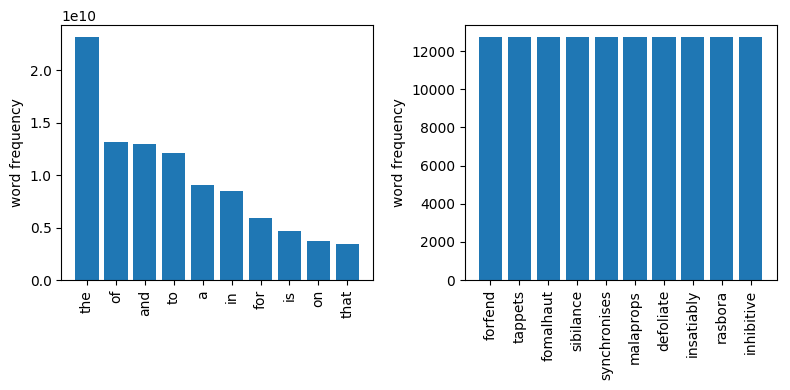

In [84]:
sorted_freq_tuples = sorted([(w, c) for w,c in freq.items()], key=lambda t: -t[1])

words, counts = zip(*sorted_freq_tuples)

plt.figure(figsize=(8,4), dpi=100)
plt.subplot(121)
plt.bar(words[:10], counts[:10])
plt.xticks(rotation='vertical')
plt.ylabel('word frequency')
plt.subplot(122)
plt.bar(words[-10:], counts[-10:])
plt.xticks(rotation='vertical')
plt.ylabel('word frequency')
plt.tight_layout()
plt.savefig('word-freqs.svg');

## Symmetric delete spelling correction ([SymSpell](https://towardsdatascience.com/symspell-vs-bk-tree-100x-faster-fuzzy-string-search-spell-checking-c4f10d80a078)) <a name="sym-spell"/>

So now have everything needed for a corrector don't we?  
As we've seen earlier, although the dynamic programming version of the edit distance implementation is orders of magnitudes faster than the recursive implementation, it still takes several seconds to provide suggestions for a word since we're computing the distance for the word in question to every other word within the dictionary. This is obviously too inefficient and takes too long to be usable.  
  
Luckily there is a solution to this problem, an algorithm called SymSpell which was developed [Wolf Garbe](https://medium.com/@wolfgarbe), founder of SeekStorm (Search-as-a-Service), FAROO (P2P Search).

### Idea: Reduce candidates to calc. edit distance for
- pre-calculate possible strings by deleting at most n chars
- store deletes in dictionary with candidate correction terms
- calc. deletes for search term and look them up in dictionary
- only calc. edit distance for terms stored as candidate corrections
- sort by edit dist. and frequency

Obviously this approach does trade memory for performance, but as the benchmarks show, it's worth the tradeoff.

In [85]:
def splits(s: str) -> List[str]:
    """ Helper function that given a string will return a list of tuples of possible splits of this word.
        E.g. splits('abc') -> [('', 'abc'), ('a', 'bc'), ('ab', 'c'), ('abc', '')]
    """
    return [(s[:i], s[i:]) for i in range(len(s)+1)]

def possible_deletions(s: str, max_edit_dist: int = 1) -> Set[str]:
    """ Helper function that, given a string and a maximal edit dist. returns a set of strings where at most
        max_edit_dist many characters have been deleted from the original string.
        E.g. possible_deletions('abc') -> {'bc', 'ac', 'ab'}
    """
    deletions = {s}
    for i in range(max_edit_dist):
        i_deletions = set()
        for word in deletions:
            split_words = splits(word)
            i_deletions |= {a+b[1:] for a,b in split_words}
        deletions |= i_deletions
    return deletions

In [86]:
class SpellingCorrector:
    """ This is the class that will offer the correction suggestion functionality and is responsible
        for preprocessing the word frequency input data and storing the resulting dictionary of partially
        deleted words and their possible corrections.
    """
    def __init__(self, filename, max_edit_dist=2):
        self._dictionary = {}
        self.max_edit_dist = max_edit_dist
        self._init_dict_with_freq_file(filename)
        
    
    def _create_dict_entry(self, word, cnt):
        """ Helper method that takes a word and it's associated count. The word and it's corresponding frequency
            is added to the dictionary. Then all possible deletions of the original word are generated. 
            Every partially deleted word is looked up in the internal dictionary.
            If it's already present, we add the original word as a possible correction to the partial word.
            If not, we create e new dictionary entry with the original word as possible correction and 
            a frequency of 0.
        """
        self._dictionary[word] = ([], int(cnt))                # initialize with no corrections and freq.
        deletes = possible_deletions(word, self.max_edit_dist) # generate all possible deletes within max_edit_dist 
        for part_word in deletes:
            if part_word in self._dictionary:
                self._dictionary[part_word][0].append(word)    # append orig. word as possible correction
            else:
                self._dictionary[part_word] = ([word], 0)      # create new entry with word as correction and freq
                                                               # set to 0

In [87]:
@add_to_class(SpellingCorrector)
def _init_dict_with_freq_file(self, filename):
    """ Helper method that reads in frequency file and 
        calls `_create_dict_entry()` on all word, freq. tuples
    """
    with open(filename) as f:
        word_cnt_tuples = [line.split() for line in f.read().split('\n') if line]
        for word, cnt in word_cnt_tuples:
            self._create_dict_entry(word, cnt)two search companies

In [88]:
class InvalidMaxEditDist(Exception):
    pass

@add_to_class(SpellingCorrector)
def _suggestion_candidates(self, word, max_edit_dist=2,
                           edit_dist_func=damerau_levenshtein,
                           verbose=False
                          ):
    """ Function that, given a word, a maximal edit distance < 0 and <= than the max_edit_dist specified at
        instantiation and a distance function, returns a dictionary containing all possible corrections of the 
        given word as keys and tuples of their distance to the passed word and their absolute frequency.
    """
    if not (0 < max_edit_dist <= self.max_edit_dist):
        raise InvalidMaxEditDist(f"max_edit_dist must be in range (0,{self.max_edit_dist}]")
    deletes = possible_deletions(word, max_edit_dist)
    # dictionary containing corrections as keys and their corresponding distance 
    # to the passed word and freq as value 
    suggestion_dict = {}                  
    # set where each word is stored for which the dist. has already been calculated
    tried_corrections = set()
    dist_func_counter = 0
    for part_word in deletes:
        # get all possible corrections that were precomputed during initialization
        corrections = self._dictionary.get(part_word, ([], 0))[0]    
        for correction in corrections:
            # avoid unnecessary computations of distance func 
            if correction not in tried_corrections:
                tried_corrections.add(correction)
                dist = edit_dist_func(correction, word)
                dist_func_counter += 1
                if  dist <= max_edit_dist:
                    # _dictionary[correction] tuple contains freq of word at second tuple position
                    suggestion_dict[correction] = (dist, self._dictionary[correction][1])
    if verbose:
        print(f"Called {edit_dist_func.__name__}() {dist_func_counter} many times.")
    return suggestion_dict


In [89]:
@add_to_class(SpellingCorrector)
def suggestions(self, word: str, verbose=False, **kwargs):
    """ Function that given a word, generates possible corrections and orders them first by their distance
        to the original string and second by their frequency.
        If verbose is True the list of words with their corresponding distances and frequencies is returned,
        otherwise just the sorted list.
    """
    word = word.lower()
    candidates = self._suggestion_candidates(word, verbose=verbose, **kwargs)
    # sort candidates first by their dsitance to words, then by their frequency
    sorted_candidates = sorted(candidates.items(), key=lambda tup: (tup[1][0], -tup[1][1]))
    if verbose:
        return sorted_candidates
    return [word for word, _ in sorted_candidates]

In [90]:
corr = SpellingCorrector('frequency_dictionary_en_82_765.txt', max_edit_dist=2)

### Small slice of the underlying dictionary structure  
  
At the heart of the algorithm is the precomputing step where we take all words from our dictionary, delete at most `max_edit_dist` characters from them and then save the original string as a possible correction of the partially deleted one.  
Following is a small slice of the dictionary that is the reusult of this precomputing step.
As we can also see, there is a lot of room for improvement memory efficiency wise (we save possible corrections even for already correctly spelled words), but since improving memory efficiency of datastructures in Python is a lost cause, we don't concern ourselves with this.

In [91]:
[(k, (data[0][:3]+['...'], data[1])) for k, data in list(corr._dictionary.items())[:5]]

[('the', (['the', 'other', 'they', '...'], 23135851162)),
 ('te', (['the', 'time', 'they', '...'], 0)),
 ('e', (['the', 'be', 'are', '...'], 0)),
 ('t', (['the', 'to', 'it', '...'], 0)),
 ('h', (['the', 'has', 'he', '...'], 0))]

## So lets benchmark it! <a name="testing-sym-spell"/>

In [92]:
time_corr = %timeit -q -o corr.suggestions("hellp", max_edit_dist=2)
f"Best: {time_corr.best} s"
corr.suggestions("hellp", verbose=True)[:5]

'Best: 0.005446554669761099 s'

Called damerau_levenshtein() 86 many times.


[('help', (1.0, 611054034)),
 ('hello', (1.0, 32960381)),
 ('hell', (1.0, 22791884)),
 ('hells', (1.0, 480906)),
 ('helle', (1.0, 143349))]

### That's a speed increase of *several* orders of magnitude!  
  
As we can see when passing `verbose=True` our distance function is only called **86 times** for the word 'hellp'. We have effectively reduced the number of candidates for which to compute the distance from ~80 thousand (size of dictionary) to 80.  

## But is the corrector actually any good? <a name="corrector-accuracy"/>
We verified that the SymSpell algorithm indeed allows us to do spelling correction blazingly fast, even in Python. 
But can the simplistic language model of looking at words independantly from their context and simply ranking them by their distance and frequency produce useful results?  
  
In order to assess this we need some test data containing words and their misspelled versions[D3].
### Misspell data  
<br>
We're using spelling error data formatted by [Roger Mitton](http://www.dcs.bbk.ac.uk/~ROGER/) to test the corrector.  
`aspell.dat`
> The aspell file contains 531 misspellings of 450 words. It is derived from one assembled by Atkinson [(click here)](http://aspell.net/test/batch0.tab) for testing the [GNU Aspell spellchecker](http://aspell.net/). 

`wikipedia.dat`
> The wikipedia file contains 2,455 misspellings of 1,922 words. It is a list of misspellings made by Wikipedia editors [(click here)](http://en.wikipedia.org/wiki/Wikipedia:List_of_common_misspellings). 

In [93]:
!echo "Aspell file:\n"
!head aspell.dat
!echo "\nWikipedia file:\n"
!head wikipedia.dat

Aspell file:

$Nevada
nevade
$Presbyterian
presbyterian
$RSX
rsx
$Stephen
Steffen
$Susan
susan

Wikipedia file:

$Apennines
Apenines
Appenines
$Athenian
Athenean
$Athenians
Atheneans
$Bernoulli
Bernouilli
$Blitzkrieg


In [94]:
def parse_misspell_data(filename):
    """ Methods that takes a misspel data filename and parses the data into a dictionary that contains 
        correct words as keys and a list of misspelled version as values.
        The method expects a file with exactly one word per line. Words that are prefixed by $ are correctly
        spelled and all following words until the next $ are misspelled versions.
    """
    with open(filename) as f:
        lines = [line for line in f.read().split('\n') if line]
        misspell_data = {}
        misspelled_words_cnt = 0
        cursor = ''
        for line in lines:
            if line.startswith('$'):
                cursor = line[1:]
                misspell_data[cursor] = []
                continue
            misspell_data[cursor].append(line)
            misspelled_words_cnt += 1
        return misspell_data, misspelled_words_cnt

In order to test and compare our correcter on the dataset we need some way of measuring it's performance. The most straightforward way is to simply take the dataset and generate for every misspelled word the correction suggestions. Then we look up if the correct word is within the first `consider_corrections_count` corrections and increment a score counter if that is the case. This serves the purpose of emulating the `Did you mean: [list of words]` feature that most (non-auto) correctors offer. 

In [95]:
def score(misspell_data: Dict[str, List[str]] ,
          corrector_func: Callable[[str], Iterable[str]] ,
          consider_corrections_count=5):
    """ Method that computes a score for a given misspell dataset, a corrector function, and 
        the consider_corrections_count which specifies how many corrections should be considered when
        determining the score.
    """
    score = 0
    for word, misspells in misspell_data.items():
        for ms_word in misspells:
            corrections = corrector_func(ms_word)
            score += 1 if word in corrections[:consider_corrections_count] else 0
    return score

In [96]:
def test_with_spell_data_and_create_graph(filename, corrector, max_edit_dist=2, max_lookup=5, verbose=False):
    """ Small helper method that simply takes the filename of misspell data with the format specified
        in `parse_misspell_data`, computes the relative score for different edit distances and maximal lookups
        and plots the results.
    """
    misspell_data, misspelled_words_cnt = parse_misspell_data(filename)
    plot_cols = max_edit_dist
    plt.figure(figsize=(4*plot_cols, 4), dpi=100)
    for edit_dist in range(1, max_edit_dist+1):
        corrector_fixed_dist = partial(corrector, max_edit_dist=edit_dist)
        score_data = [score(misspell_data, corrector_fixed_dist, lookup)/misspelled_words_cnt 
                      for lookup in range(1, max_lookup+1)]
        if verbose:
            print(f"Score data for {filename} with max edit dist {edit_dist}: {score_data}")
        plt.subplot(1, plot_cols, edit_dist);
        plt.gca().set_ylim([0, 1.0]);
        plt.bar(range(1, max_lookup+1), score_data);
        plt.title(f"Max edit dist: {edit_dist}");
        plt.ylabel('score in %');
        plt.xlabel('max lookup');
    plt.tight_layout();
    plt.savefig(f'{filename}-score-graph.svg');

Score data for aspell.dat with max edit dist 1: [0.3860640301318267, 0.4613935969868173, 0.4839924670433145, 0.4915254237288136, 0.4934086629001883, 0.4934086629001883, 0.4934086629001883, 0.4952919020715631, 0.4952919020715631, 0.4952919020715631]
Score data for aspell.dat with max edit dist 2: [0.5103578154425612, 0.64030131826742, 0.6836158192090396, 0.7024482109227872, 0.71939736346516, 0.7212806026365348, 0.7288135593220338, 0.7306967984934086, 0.7306967984934086, 0.7325800376647834]
Score data for wikipedia.dat with max edit dist 1: [0.6545824847250509, 0.734826883910387, 0.7523421588594704, 0.7596741344195519, 0.7629327902240326, 0.7641547861507129, 0.764562118126273, 0.7657841140529531, 0.7665987780040733, 0.7674134419551935]
Score data for wikipedia.dat with max edit dist 2: [0.7340122199592668, 0.835030549898167, 0.8668024439918534, 0.8806517311608961, 0.8887983706720978, 0.8928716904276985, 0.8965376782077393, 0.8993890020366598, 0.9014256619144603, 0.9022403258655805]


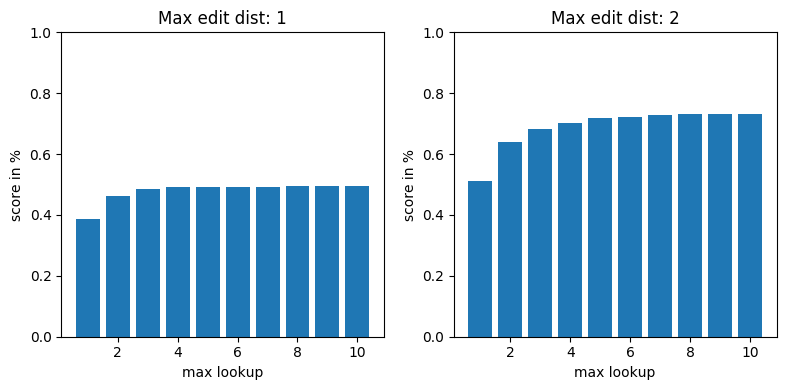

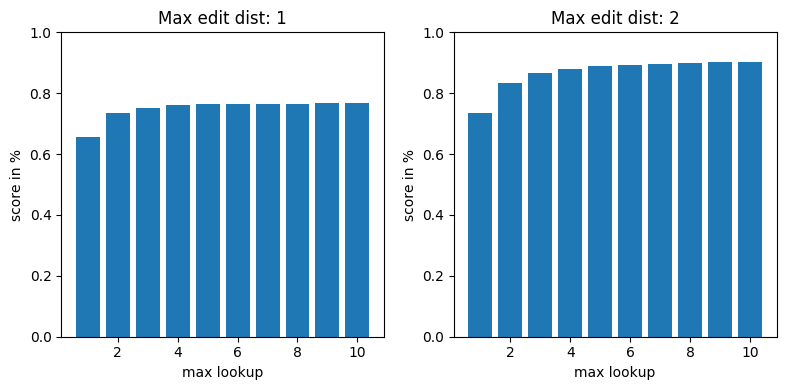

In [97]:
test_with_spell_data_and_create_graph('aspell.dat', corr.suggestions, max_lookup=10, verbose=True);
test_with_spell_data_and_create_graph('wikipedia.dat', corr.suggestions, max_lookup=10, verbose=True);

Looking at the results from benchmarking the corrector it is suprisingly effective. On the aspell data set the correct word is contained within in the 5 highest ranked suggestions nearly 72% of the time (using a max edit distance of 2). Increasing the maximal lookup to 10 items increases the accuracy to ~73.3%.
Even better are the results on the wikipedia dataset where the accuracy is 88.9% for a lookup of 5 items. Increasing the lookup to 10 items results in an accuracy of 90.2%.
The difference in the datasets are due to the aspell dataset containing more serious spelling mistakes than the wikipedia dataset.

## Spelling correction: Conclusion <a name="correcting-conclusion"/>

Utilizing the SymSpell algorithm and a carefully composed word frequency file it is possible to achieve both accurate and performant spelling correction.  
The accuracy of the correction could be further increased by weighing the distance between words and their respective frequencys differently. When ranking the correction suggestions it might bebeneficial to rank a word, that has a distance of 2 from the originial and a very high freqeuency, higher than a word that has a distance of 1 but is only very rarely used within the language.  
Another measure that would likely increase performance is using n-gram (contigous sequence of n words) data, in order to consider the context that words appear in.  
The run time and memory efficiency could be further optimized by using a fast compiled language and using datastructures that are able to store strings efficiently, a trie or directed acyclic word graph could be used.

# References  <a name="references"/>

1. Bentley, John (1985): programming pearls, A spelling checker. In: Communications of the ACM, Volume 28 Number 5
2. Garbe, Wolf (2012): 1000x Faster Spelling Correction algorithm, Wolf, [online] [medium.com](https://medium.com/@wolfgarbe/1000x-faster-spelling-correction-algorithm-2012-8701fcd87a5f) [accessed 16.06.2018]
3. McIlroy, Malcolm Douglas (1971-1986): A research UNIX Reader: Annotated Excerpts from the Programmer’s Manual, [online] [cs.dartmouth.edu](http://www.cs.dartmouth.edu/~doug/reader.pdf) [accessed 12.06.2018]
4. Norvig, Peter (2007-2016): How to Write a Spelling Corrector, [online] [norvig.com](http://norvig.com/spell-correct.html) [accessed 16.06.2018]  

## Data sources <a name="data-sources"/>
1. `big.txt`, Peter Norvig, [norvig.com](http://norvig.com/big.txt), [accessed 16.06.2018]
2. `frequency_dictionary_en_82_765.txt`, Wolf Garbe, [github.com](https://github.com/wolfgarbe/SymSpell/blob/master/SymSpell/frequency_dictionary_en_82_765.txt), [accessed 16.06.2018]
3. `aspell.dat` and `wikipedia.dat`, Roger Mitton, [dcs.bbk.ac.uk](http://www.dcs.bbk.ac.uk/~ROGER/corpora.html), [accessed 16.06.2018]

## Libraries <a name="libraries"/>
- [marisa_trie](https://github.com/pytries/marisa-trie) (MIT license)  
- [matplotlib](https://github.com/matplotlib/matplotlib)  
- [memory-profiler](https://github.com/pythonprofilers/memory_profiler) (BSD-new license)
- [numpy](https://github.com/numpy/numpy) (BSD-new license)  
- [pympler](https://github.com/pympler/pympler) (Apache-2.0)